In this notebook we calculated user sessions from logged data. 
We compared our calculated sessions to visit_ids that are defined in the client code.
https://jira.dev.bbc.co.uk/browse/DATALAB-1950

SQL query partitioned by dt
```sql
WITH 
aux AS
(
  SELECT
  hashed_id,
  from_big_endian_64(xxhash64(to_utf8(hashed_id))) AS user_id,
  source,
  page_name,
  visit_id,
  time_spent_per_visit,
  dt,
  event_start_datetime,
  LAG(event_start_datetime) OVER(PARTITION BY hashed_id ORDER BY event_start_datetime) AS previous_time
FROM "audience"."audience_activity"
WHERE dt BETWEEN '20190901'AND '20190930'
AND hashed_id is NOT null AND NOT hashed_id='undefined'
AND destination='PS_VOICE'
AND from_big_endian_64(xxhash64(to_utf8(hashed_id))) % 500= 42
),

aux2 AS
(
    SELECT *
    , date_diff('minute',date_parse(previous_time,'%Y-%m-%dT%H:%i:%s')
    , date_parse(event_start_datetime,'%Y-%m-%dT%H:%i:%s')) as difference
    FROM aux
),

aux3 AS
(
    SELECT *, 
    CASE
        WHEN 0<=difference and difference <=30 THEN 0
        WHEN difference>30 THEN 1
        -- this case catches the first session for each user
        WHEN difference IS NULL THEN 1
    END AS session_boolean
  
FROM aux2
)
  
SELECT 
*, 
SUM(session_boolean) OVER(PARTITION BY dt ORDER BY dt, user_id, event_start_datetime) AS session_id
FROM aux3
```

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 500)

In [2]:
df=pd.read_csv("data/partitionedbydtorderedbydt.csv")

In [3]:
df.head(n=50)

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,session_id
0,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.amazon-direct-routed-radio.page,1049452,Less than 10 sec,20190901,2019-09-01T09:02:11,NaN,NaN,1,1
1,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,AV,bbc radio fourfm,1049452,Less than 10 sec,20190901,2019-09-01T09:02:16,2019-09-01T09:02:16,0.0,0,1
2,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.radio.play-radio.page,1049452,Less than 10 sec,20190901,2019-09-01T09:02:16,2019-09-01T09:02:11,0.0,0,1
3,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.radio.pause-radio.page,1713952,No time,20190901,2019-09-01T10:46:07,2019-09-01T09:02:16,103.0,1,2
4,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.amazon-direct-routed-radio.page,3475512,Between 20 mins and 30 mins,20190901,2019-09-01T18:31:57,2019-09-01T10:46:07,465.0,1,3
5,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,AV,bbc 6music,3475512,Between 20 mins and 30 mins,20190901,2019-09-01T18:32:03,2019-09-01T18:32:03,0.0,0,3
6,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.radio.play-radio.page,3475512,Between 20 mins and 30 mins,20190901,2019-09-01T18:32:03,2019-09-01T18:31:57,0.0,0,3
7,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.radio.pause-radio.page,3475512,Between 20 mins and 30 mins,20190901,2019-09-01T18:45:02,2019-09-01T18:45:02,0.0,0,3
8,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,AV,bbc 6music,3475512,Between 20 mins and 30 mins,20190901,2019-09-01T18:45:02,2019-09-01T18:32:03,12.0,0,3
9,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.radio.play-radio.page,3475512,Between 20 mins and 30 mins,20190901,2019-09-01T18:45:08,2019-09-01T18:45:08,0.0,0,3


In [4]:
df.nunique()

hashed_id                 376
user_id                   376
source                      2
page_name                 193
visit_id                 9920
time_spent_per_visit       10
dt                         30
event_start_datetime    31189
previous_time           31020
difference               2461
session_boolean             2
session_id                361
dtype: int64

Session_id is a session id that we calculated, visit_id is a a session_id present in a client code
Both of these fields are partioned by dt (i.e. the count of sessions/visits resets at midnight), so they need to be combined with dt to give us a unique field.

In [5]:
#Create a unique session id by combining a daily session id with dt
def create_session_id(row):
    return str(row["dt"]) + str(row.session_id)

df = (
    df
    .assign(session_id_date = df.apply(create_session_id, axis=1))
)

In [6]:
df.nunique()

hashed_id                 376
user_id                   376
source                      2
page_name                 193
visit_id                 9920
time_spent_per_visit       10
dt                         30
event_start_datetime    31189
previous_time           31020
difference               2461
session_boolean             2
session_id                361
session_id_date          9297
dtype: int64

In [7]:
# From our research we know that the visit_id field is not unique on its own (it's a count of visitors of a particular website each day).
# We will combine it with the dt field to make it unique.
def create_visit_id_date(row):
    return str(row["dt"]) + str(row.visit_id)

df = (
    df
    .assign(visit_id_date = df.apply(create_visit_id_date, axis=1))
)

df.head()

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,session_id,session_id_date,visit_id_date
0,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.amazon-direct-routed-radio.page,1049452,Less than 10 sec,20190901,2019-09-01T09:02:11,NaN,NaN,1,1,201909011,201909011049452
1,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,AV,bbc radio fourfm,1049452,Less than 10 sec,20190901,2019-09-01T09:02:16,2019-09-01T09:02:16,0.0,0,1,201909011,201909011049452
2,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.radio.play-radio.page,1049452,Less than 10 sec,20190901,2019-09-01T09:02:16,2019-09-01T09:02:11,0.0,0,1,201909011,201909011049452
3,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.radio.pause-radio.page,1713952,No time,20190901,2019-09-01T10:46:07,2019-09-01T09:02:16,103.0,1,2,201909012,201909011713952
4,TvxNptdOxqmeyfEuySsHoLWSkJohnP8toKYhbStrbuc,15815204040017042,Events,voice.alexa.amazon-direct-routed-radio.page,3475512,Between 20 mins and 30 mins,20190901,2019-09-01T18:31:57,2019-09-01T10:46:07,465.0,1,3,201909013,201909013475512


In [8]:
df['visit_id_date'].nunique()

9973

In [9]:
#Comparison between session_id and visit_id.
dist=pd.DataFrame(df[['session_id_date','visit_id_date',]].copy(), columns=['session_id_date','visit_id_date'])
dist.nunique()

session_id_date    9297
visit_id_date      9973
dtype: int64

There are more unique visit_ids than session_ids. 
We would expect than on average an individual session_id encompasses more events than a visit_id.
Also, the same session_id might have a few different visit_ids assign to it (the total number of events adds up).

In [10]:
#count unique combinations
df_noduplicates=df[['visit_id_date','session_id_date',]].drop_duplicates()
df_noduplicates

,visit_id_date,session_id_date
0,201909011049452,201909011
3,201909011713952,201909012
4,201909013475512,201909013
13,20190901146351,201909014
16,20190901459451,201909015
...,...,...
48967,201909213824582,20190921299
48968,201909212370972,20190921300
48971,201909212513342,20190921301
48980,20190921222531,20190921302


In [11]:
#Count how many visit_id fields belong to an individual session_id.
df_noduplicates['session_id_date'].value_counts()

2019090980     5
20190901109    5
2019091620     4
20190929132    4
20190908119    4
              ..
2019090196     1
20190923292    1
20190912307    1
20190918212    1
20190930127    1
Name: session_id_date, Length: 9297, dtype: int64

Text(0.5, 0, 'Number of visit_ids with the same session_id')

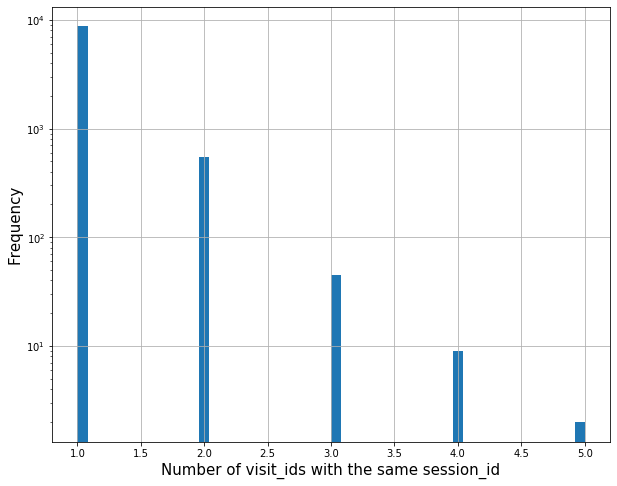

In [12]:
plt.figure(figsize=[10,8])
plt.yscale('log')
df_noduplicates['session_id_date'].value_counts().hist(bins=50)
plt.ylabel('Frequency',fontsize=15)
plt.xlabel('Number of visit_ids with the same session_id',fontsize=15)

Next few examples illustrate how the same session id can be assigned multiple visit ids.

In [13]:
df[df['session_id_date']=='2019090980']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,session_id,session_id_date,visit_id_date
10171,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,Events,voice.alexa.amazon-direct-routed-radio.page,1073482,Between 5 min and 10 min,20190909,2019-09-09T07:31:40,2019-09-09T06:57:25,34.0,1,80,2019090980,201909091073482
10172,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,AV,bbc radio five live,1073482,Between 5 min and 10 min,20190909,2019-09-09T07:31:45,2019-09-09T07:31:40,0.0,0,80,2019090980,201909091073482
10173,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,Events,voice.alexa.radio.play-radio.page,1073482,Between 5 min and 10 min,20190909,2019-09-09T07:31:45,2019-09-09T07:31:45,0.0,0,80,2019090980,201909091073482
10174,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,Events,voice.alexa.radio.pause-radio.page,1073482,Between 5 min and 10 min,20190909,2019-09-09T07:41:27,2019-09-09T07:31:45,9.0,0,80,2019090980,201909091073482
10175,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,AV,bbc radio five live,1073482,Between 5 min and 10 min,20190909,2019-09-09T07:41:27,2019-09-09T07:41:27,0.0,0,80,2019090980,201909091073482
10176,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,Events,voice.alexa.amazon-direct-routed-radio.page,1283512,Less than 10 sec,20190909,2019-09-09T08:05:05,2019-09-09T07:41:27,23.0,0,80,2019090980,201909091283512
10177,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,Events,voice.alexa.radio.play-radio.page,1283512,Less than 10 sec,20190909,2019-09-09T08:05:10,2019-09-09T08:05:05,0.0,0,80,2019090980,201909091283512
10178,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,AV,bbc radio two,1283512,Less than 10 sec,20190909,2019-09-09T08:05:10,2019-09-09T08:05:10,0.0,0,80,2019090980,201909091283512
10179,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,Events,voice.alexa.amazon-direct-routed-radio.page,1330252,Between 10 mins and 20 mins,20190909,2019-09-09T08:12:55,2019-09-09T08:05:10,7.0,0,80,2019090980,201909091330252
10180,BV-tK20XBYEpT7SpDdKVvVmS2BUk-h0Qr7RT0u0nKLE,2236064500548568542,Events,voice.alexa.radio.play-radio.page,1330252,Between 10 mins and 20 mins,20190909,2019-09-09T08:13:01,2019-09-09T08:12:55,0.0,0,80,2019090980,201909091330252


In [14]:
df[df['session_id_date']=='20190901109']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,session_id,session_id_date,visit_id_date
544,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,Events,voice.alexa.radio.pause-radio.page,110102,Less than 10 sec,20190901,2019-09-01T05:21:30,NaN,NaN,1,109,20190901109,20190901110102
545,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,Events,voice.alexa.radio.play-radio.page,110102,Less than 10 sec,20190901,2019-09-01T05:21:31,2019-09-01T05:21:30,0.0,0,109,20190901109,20190901110102
546,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,AV,bbc radio fourfm,110102,Less than 10 sec,20190901,2019-09-01T05:21:31,2019-09-01T05:21:31,0.0,0,109,20190901109,20190901110102
547,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,Events,voice.alexa.radio.pause-radio.page,108451,Between 2 mins and 5 mins,20190901,2019-09-01T05:21:34,2019-09-01T05:21:31,0.0,0,109,20190901109,20190901108451
548,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,AV,bbc radio fourfm,108451,Between 2 mins and 5 mins,20190901,2019-09-01T05:21:36,2019-09-01T05:21:34,0.0,0,109,20190901109,20190901108451
549,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,Events,voice.alexa.radio.play-radio.page,108451,Between 2 mins and 5 mins,20190901,2019-09-01T05:21:36,2019-09-01T05:21:36,0.0,0,109,20190901109,20190901108451
550,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,Events,voice.alexa.radio.pause-radio.page,108451,Between 2 mins and 5 mins,20190901,2019-09-01T05:26:08,2019-09-01T05:26:08,0.0,0,109,20190901109,20190901108451
551,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,AV,bbc radio fourfm,108451,Between 2 mins and 5 mins,20190901,2019-09-01T05:26:08,2019-09-01T05:21:36,4.0,0,109,20190901109,20190901108451
552,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,Events,voice.alexa.radio.play-radio.page,108451,Between 2 mins and 5 mins,20190901,2019-09-01T05:26:11,2019-09-01T05:26:11,0.0,0,109,20190901109,20190901108451
553,k-IBLE0X2reDZ6fgBScXLPqjk1Ocy-bHptInAQ8T6gs,3542425941669049542,AV,bbc radio fourfm,108451,Between 2 mins and 5 mins,20190901,2019-09-01T05:26:11,2019-09-01T05:26:08,0.0,0,109,20190901109,20190901108451


In [15]:
df[df['session_id_date']=='20190929132']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,session_id,session_id_date,visit_id_date
25337,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,Events,voice.alexa.amazon-direct-routed-radio.page,1272112,Between 2 mins and 5 mins,20190929,2019-09-29T09:44:15,2019-09-29T08:21:57,82.0,1,132,20190929132,201909291272112
25338,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,AV,bbc radio two,1272342,Between 2 mins and 5 mins,20190929,2019-09-29T09:44:18,2019-09-29T09:44:15,0.0,0,132,20190929132,201909291272342
25339,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,Events,voice.alexa.radio.play-radio.page,1272342,Between 2 mins and 5 mins,20190929,2019-09-29T09:44:18,2019-09-29T09:44:18,0.0,0,132,20190929132,201909291272342
25340,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,Events,voice.alexa.close.page,1272112,Between 2 mins and 5 mins,20190929,2019-09-29T09:48:26,2019-09-29T09:44:18,4.0,0,132,20190929132,201909291272112
25341,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,AV,bbc radio two,1272342,Between 2 mins and 5 mins,20190929,2019-09-29T09:48:27,2019-09-29T09:48:26,0.0,0,132,20190929132,201909291272342
25342,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,Events,voice.alexa.radio.pause-radio.page,1272342,Between 2 mins and 5 mins,20190929,2019-09-29T09:48:27,2019-09-29T09:48:27,0.0,0,132,20190929132,201909291272342
25343,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,Events,voice.alexa.close.page,1446712,No time,20190929,2019-09-29T10:08:52,2019-09-29T09:48:27,20.0,0,132,20190929132,201909291446712
25344,VeLqjAPgQrnaTRUC6zm9fFpaWxz5QKbe2c85Gy-D6JI,4582733641588056042,Events,voice.alexa.radio.pause-radio.page,1446722,No time,20190929,2019-09-29T10:08:53,2019-09-29T10:08:52,0.0,0,132,20190929132,201909291446722


In [16]:
df[df['session_id_date']=='20190902292']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,session_id,session_id_date,visit_id_date
39549,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,Events,voice.alexa.amazon-direct-routed-radio.page,692612,Less than 10 sec,20190902,2019-09-02T06:57:34,NaN,NaN,1,292,20190902292,20190902692612
39550,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,AV,bbc radio one,692612,Less than 10 sec,20190902,2019-09-02T06:57:40,2019-09-02T06:57:40,0.0,0,292,20190902292,20190902692612
39551,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,Events,voice.alexa.radio.play-radio.page,692612,Less than 10 sec,20190902,2019-09-02T06:57:40,2019-09-02T06:57:34,0.0,0,292,20190902292,20190902692612
39552,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,Events,voice.alexa.amazon-direct-routed-radio.page,773741,30 mins or more,20190902,2019-09-02T07:08:37,2019-09-02T06:57:40,10.0,0,292,20190902292,20190902773741
39553,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,Events,voice.alexa.radio.play-radio.page,773741,30 mins or more,20190902,2019-09-02T07:08:43,2019-09-02T07:08:43,0.0,0,292,20190902292,20190902773741
39554,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,AV,bbc radio one,773741,30 mins or more,20190902,2019-09-02T07:08:43,2019-09-02T07:08:37,0.0,0,292,20190902292,20190902773741
39555,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,Events,voice.alexa.radio.pause-radio.page,773741,30 mins or more,20190902,2019-09-02T07:10:12,2019-09-02T07:10:12,0.0,0,292,20190902292,20190902773741
39556,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,AV,bbc radio one,773741,30 mins or more,20190902,2019-09-02T07:10:12,2019-09-02T07:08:43,1.0,0,292,20190902292,20190902773741
39557,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,AV,bbc radio one,773741,30 mins or more,20190902,2019-09-02T07:10:13,2019-09-02T07:10:12,0.0,0,292,20190902292,20190902773741
39558,h7hnGi3UAPh2dwUbIp3tkVgrc0TMQS9HTBxuLnYRhYU,8145849350829055042,Events,voice.alexa.radio.play-radio.page,773741,30 mins or more,20190902,2019-09-02T07:10:13,2019-09-02T07:10:13,0.0,0,292,20190902292,20190902773741


In [17]:
df[df['session_id_date']=='2019091620']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,session_id,session_id_date,visit_id_date
40135,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,Events,voice.alexa.amazon-direct-routed-radio.page,340291,Between 10 sec and 30 sec,20190916,2019-09-16T06:00:45,2019-09-14T09:22:49,2677.0,1,20,2019091620,20190916340291
40136,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,Events,voice.alexa.radio.play-radio.page,340291,Between 10 sec and 30 sec,20190916,2019-09-16T06:00:51,2019-09-16T06:00:45,0.0,0,20,2019091620,20190916340291
40137,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,AV,bbc radio two,340291,Between 10 sec and 30 sec,20190916,2019-09-16T06:00:51,2019-09-16T06:00:51,0.0,0,20,2019091620,20190916340291
40138,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,Events,voice.alexa.radio.pause-radio.page,340291,Between 10 sec and 30 sec,20190916,2019-09-16T06:01:00,2019-09-16T06:00:51,0.0,0,20,2019091620,20190916340291
40139,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,AV,bbc radio two,340291,Between 10 sec and 30 sec,20190916,2019-09-16T06:01:00,2019-09-16T06:01:00,0.0,0,20,2019091620,20190916340291
40140,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,Events,voice.alexa.radio.play-radio.page,340291,Between 10 sec and 30 sec,20190916,2019-09-16T06:01:04,2019-09-16T06:01:04,0.0,0,20,2019091620,20190916340291
40141,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,AV,bbc radio two,340291,Between 10 sec and 30 sec,20190916,2019-09-16T06:01:04,2019-09-16T06:01:00,0.0,0,20,2019091620,20190916340291
40142,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,Events,voice.alexa.amazon-direct-routed-radio.page,471342,Between 20 mins and 30 mins,20190916,2019-09-16T06:17:28,2019-09-16T06:01:04,16.0,0,20,2019091620,20190916471342
40143,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,Events,voice.alexa.radio.play-radio.page,471342,Between 20 mins and 30 mins,20190916,2019-09-16T06:17:34,2019-09-16T06:17:28,0.0,0,20,2019091620,20190916471342
40144,kprs9cvAyl5PlaF1TlwYIENxOxmWw6Pq3iwlZteUczM,640496641722447542,AV,bbc radio two,471342,Between 20 mins and 30 mins,20190916,2019-09-16T06:17:34,2019-09-16T06:17:34,0.0,0,20,2019091620,20190916471342


Differences between a visit_id and a a session_id:

-a new session id is initiated if no activitity was registered for more than 30 minutes

-a new visit is is initiated if no activitity was registered for more than 30 minutes, but sometimes it gets initiated more often. We are not sure why.


In [18]:
df_noduplicates['visit_id_date'].value_counts()

20190915385762     1
201909062452972    1
20190912601801     1
20190909625042     1
201909282873881    1
                  ..
201909031457982    1
201909281917472    1
201909043784391    1
201909213761742    1
201909233866992    1
Name: visit_id_date, Length: 9973, dtype: int64

An visit_id field has only one session_id field that corresponds to it.

In [19]:
#Count number of events registered per session
aux_df=df['session_id_date'].value_counts().reset_index()
aux_df

,index,session_id_date
0,20190918135,235
1,2019091553,113
2,20190927109,107
3,2019092627,102
4,20190904302,77
...,...,...
9292,20190910258,1
9293,20190925243,1
9294,2019092128,1
9295,2019091273,1


In [20]:
#Count number of events registered per visit
aux2_df=df['visit_id_date'].value_counts().reset_index()
aux2_df

,index,visit_id_date
0,201909183984862,235
1,201909152869751,113
2,201909271082922,107
3,20190926257642,80
4,20190904152222,77
...,...,...
9968,201909241549982,1
9969,201909112297642,1
9970,201909094103291,1
9971,201909271322282,1


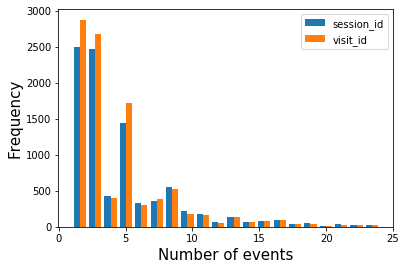

In [21]:
x=aux_df[aux_df['session_id_date']<25]['session_id_date']
y=aux2_df[aux2_df['visit_id_date']<25]['visit_id_date']

plt.hist([x, y], bins=20, label=['session_id','visit_id'])
plt.legend(loc='upper right')
plt.ylabel('Frequency',fontsize=15)
plt.xlabel('Number of events',fontsize=15)
plt.show()


This plot confirms our earlier expactations: 

on average an individual visit_id corresponds to fewer events than an individual session_id.